In [64]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patchess
import matplotlib.gridspec as gridspec
from skimage import transform, filters
import sys, os
#import operator
#import csv

%matplotlib notebook

%load_ext autoreload
%autoreload 2

import caffe # this should be the version from https://github.com/jimmie33/Caffe-ExcitationBP

from helpers import *
from heatmaps import *
from optimize_mask import *
from figures import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# TODO: Change this to your own Caffe-ExcitationBP directory
caffe_dir = '/home/ruthfong/sample_code/Caffe-ExcitationBP/'

save_figs = False
if save_figs:
    # TODO: Change to a preferred figures directory
    fig_dir = '/home/ruthfong/neural_coding/paper_figures/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

In [37]:
gpu = 0
net_type = 'googlenet'

if gpu is not None:
    caffe.set_device(gpu)
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()
    
net = get_net(net_type)

In [81]:
labels_desc = np.loadtxt(os.path.join(caffe_dir, 'data/ilsvrc12/synset_words.txt'), str, delimiter='\t')
synsets = np.loadtxt(os.path.join(caffe_dir, 'data/ilsvrc12/synsets.txt'), str, delimiter='\t')
indexing = np.loadtxt('../../../data/ilsvrc12/ascii_order_to_synset_order.txt')
(paths, labels) = read_imdb('../../../data/ilsvrc12/annotated_train_heldout_imdb.txt')
data_desc = 'train_heldout'

# Set generate_ann_dir = True to create a dir containing only the 5000 heldout training images' bounding box annotations (one-time only)
# Download ImageNet bounding box here: http://image-net.org/Annotation/Annotation.tar.gz 
# (from http://image-net.org/download-bboxes)
# TODO set orig_ilsvrc_ann_dir to the unzipped Annotation dir and ann_dir to where you want to save the heldout ann dir
generate_ann_dir = False
if generate_ann_dir:
    orig_ilsvrc_ann_dir = '/data/ruthfong/ILSVRC2012/Annotation'
    ann_dir = '/data/ruthfong/ILSVRC2012/annotated_train_heldout_ground_truth_annotations'
    create_heldout_annotated_dir(orig_ilsvrc_ann_dir, ann_dir, 
                                 imdb='../../../data/ilsvrc12/annotated_train_heldout_imdb.txt')
else:
    ann_dir = '/data/ruthfong/ILSVRC2012/annotated_train_heldout_ground_truth_annotations'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

# TODO replace with mask dir (ideally holding learned masks from the 5000 heldout training images)
# though most examples can be generated in this notebook, in which case make mask_dir the location in which
# you want to save the learned masks and set generate_masks = True
generate_masks = False
mask_dir = '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
if generate_masks == False:
    mask_paths = [os.path.join(mask_dir, '%d.npy' % x) for x in range(len(labels))]
    
    # TODO replace with dir containing constant and noise masks for Figure 4 (can also generate the relevant masks in this notebook)
    constant_mask_dir = '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_mean_img/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
    constant_mask_paths = [os.path.join(constant_mask_dir, '%d.npy' % x) for x in range(len(labels))]
    noise_mask_dir = '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_random_noise/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
    noise_mask_paths = [os.path.join(noise_mask_dir, '%d.npy' % x) for x in range(len(labels))]

# Splash Figure (Figure 1)

<IPython.core.display.Javascript object>


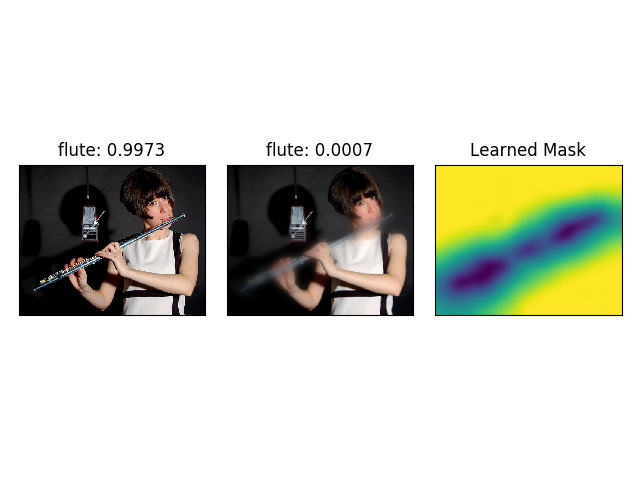

In [29]:
ind = 7
if save_figs:
    fig_path = os.path.join(fig_dir, 'splash_%d.pdf' % ind)
else:
    fig_path = None
if generate_masks:
    mask_path = os.path.join(mask_dir, '%d.npy' % ind)
    generate_learned_mask(net, paths[ind], labels[ind], mask_path = mask_path, gpu = gpu, show_fig = False)
    generate_splash_img(net, paths[ind], labels[ind], mask_path, perturbation = 'blur', fig_path = fig_path)
else:
    generate_splash_img(net, paths[ind], labels[ind], mask_paths[ind], perturbation = 'blur', fig_path = fig_path)

# Compare with Other Saliency Methods (Figure 2)

<IPython.core.display.Javascript object>


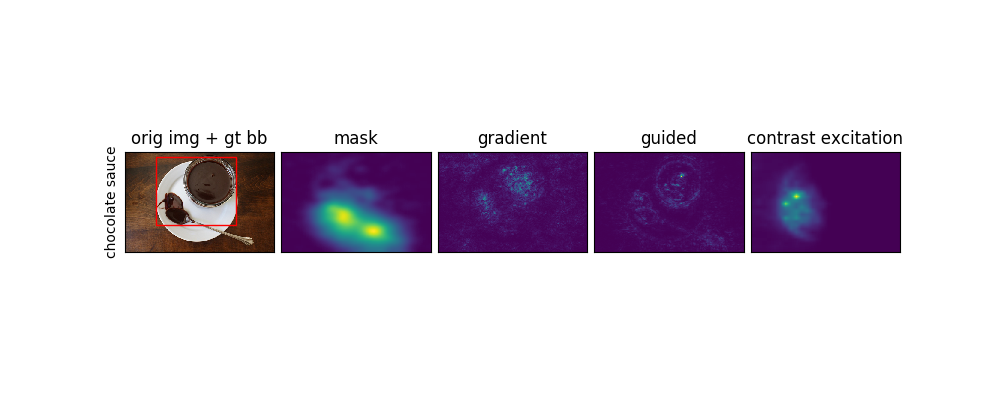

<IPython.core.display.Javascript object>


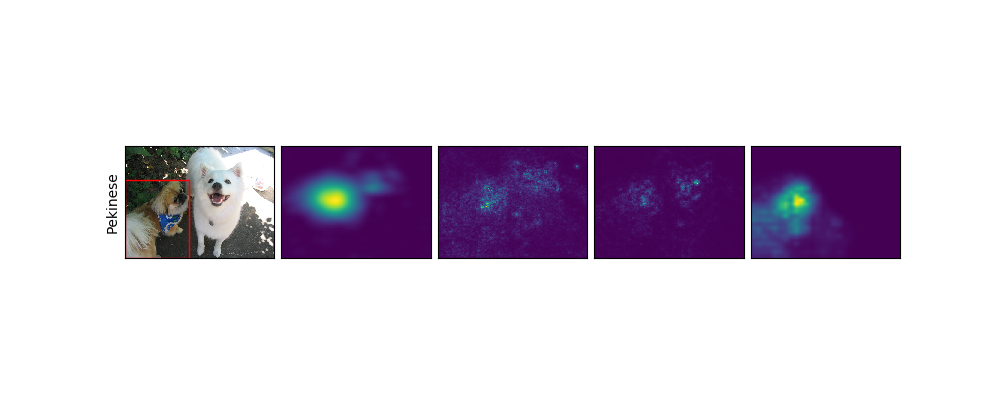

<IPython.core.display.Javascript object>


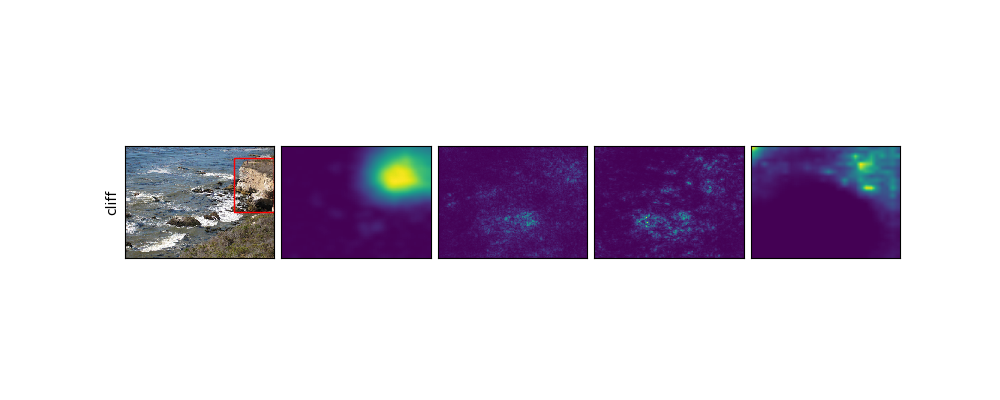

<IPython.core.display.Javascript object>


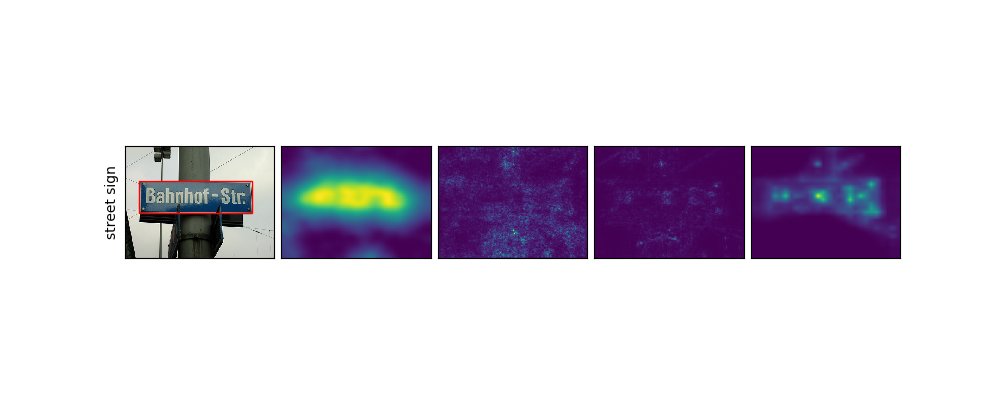

<IPython.core.display.Javascript object>


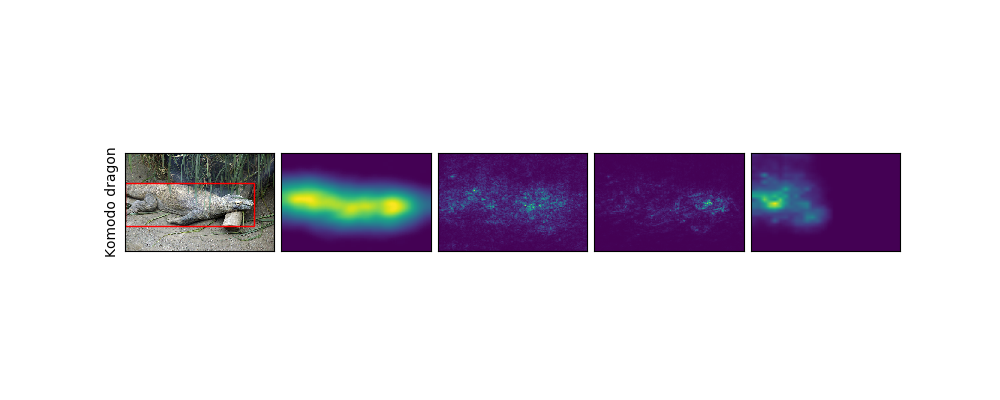

<IPython.core.display.Javascript object>


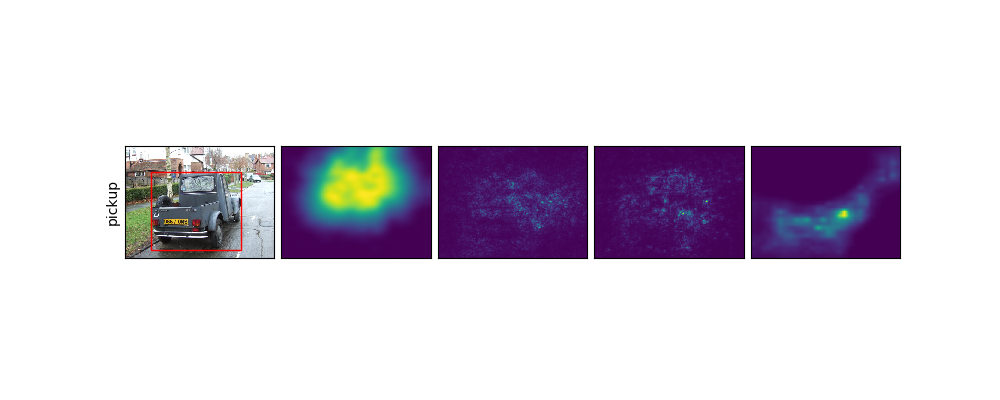

<IPython.core.display.Javascript object>


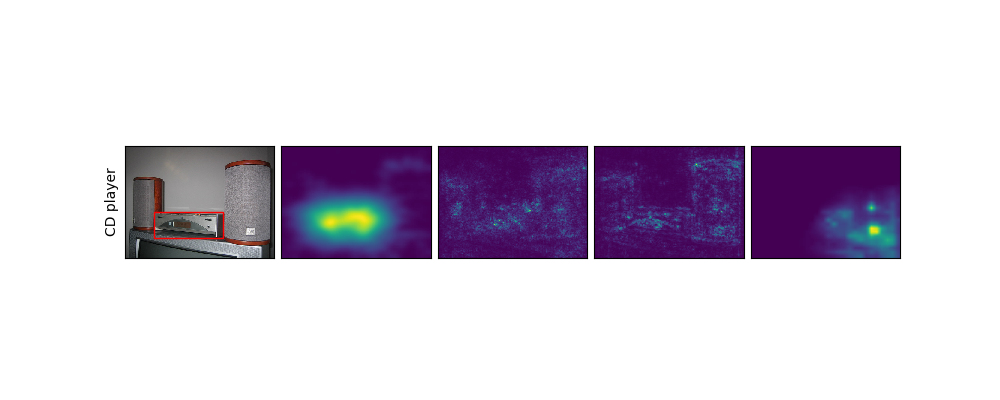

<IPython.core.display.Javascript object>


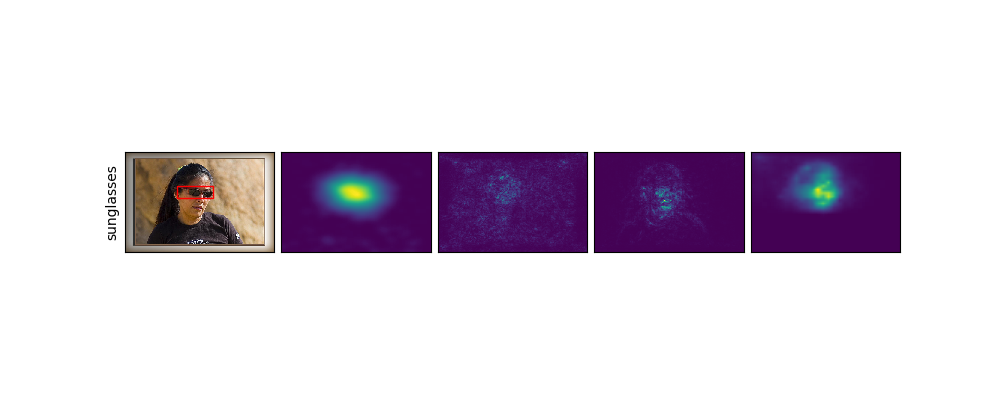

<IPython.core.display.Javascript object>


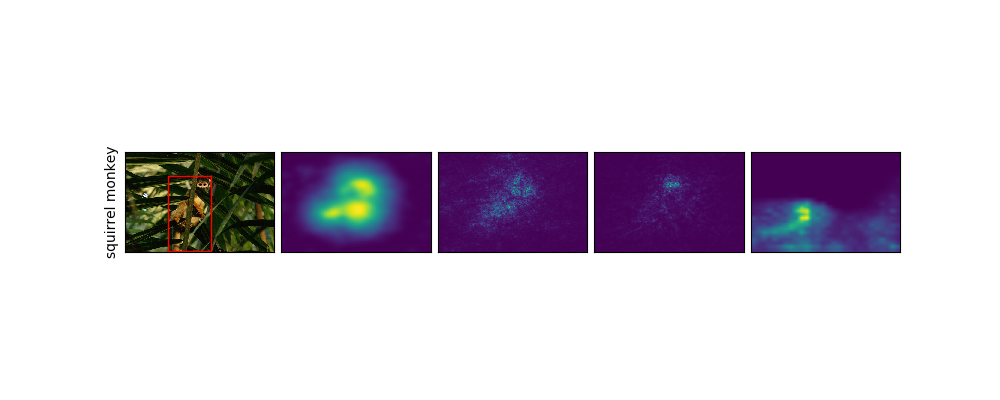

In [30]:
interested_idx = [12, 10, 11, 17, 151, 30, 79, 322, 186]
for i in range(len(interested_idx)):
    img_path = paths[interested_idx[i]]
    ann_path = ann_paths[interested_idx[i]]
    label = labels[interested_idx[i]]
    if generate_masks:
        mask_path = os.path.join(mask_dir, '%d.npy' % interested_idx[i])
        generate_learned_mask(net, img_path, label, mask_path = mask_path, gpu = gpu, show_fig = False)
    else:
        mask_path = mask_paths[interested_idx[i]]
    fig_path = None
    show_titles = False
    fig_sub = ''
    if i == 0:
        show_titles = True
        fig_sub = '_w_titles'
    if save_figs:
        fig_path = os.path.join(fig_dir, 'compare_saliency_%d%s.pdf' % (i, fig_sub))
    visualize_heatmaps(net, img_path, mask_path, label, ann_path = ann_path, show_titles = show_titles, 
                       show_bbs = False, mask_flip = True, thres_first = True, fig_path = fig_path, gpu = gpu, 
                       synsets = synsets, indexing = indexing)

# Template Matching Figure (Figure 3)
(Simonyan et al., 2014)

<IPython.core.display.Javascript object>


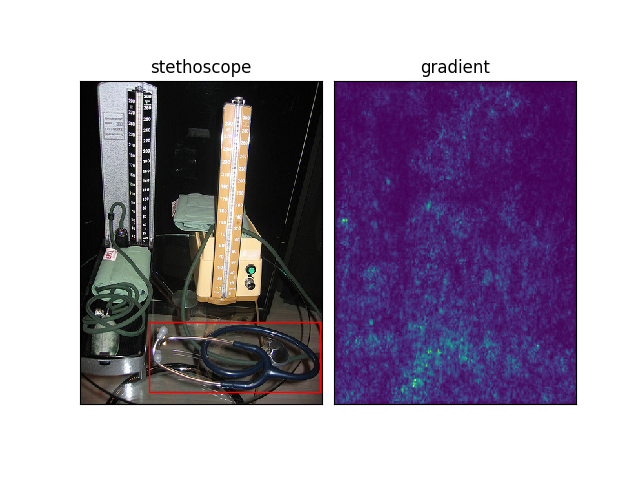

<IPython.core.display.Javascript object>


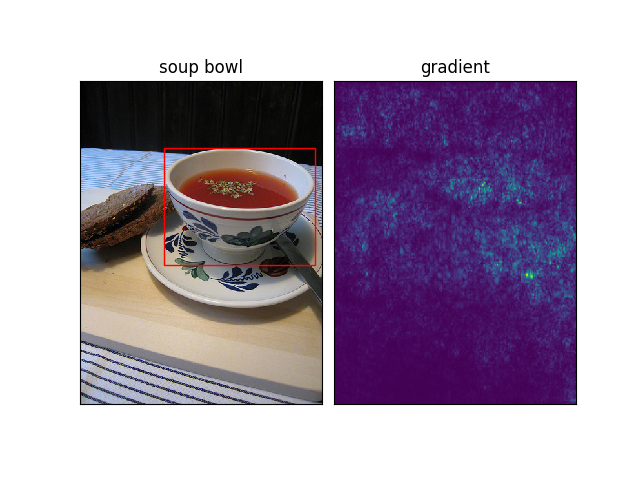

In [42]:
interested_idx = [0,14] # interested_idx = [0,7,13,14]
for i in interested_idx:
    if save_figs:
        fig_path = os.path.join(fig_dir, 'saliency_%d.pdf' % i)
    else:
        fig_path = None
    show_saliency_map(net, paths[i], labels[i], ann_path = ann_paths[i], gpu = gpu, 
                     fig_path = fig_path)

# Perturbations Figure (Figure 4)

<IPython.core.display.Javascript object>


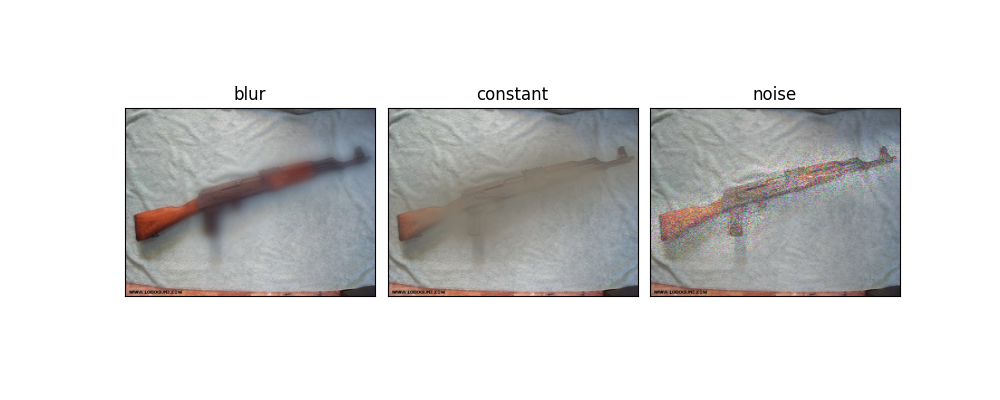

<IPython.core.display.Javascript object>


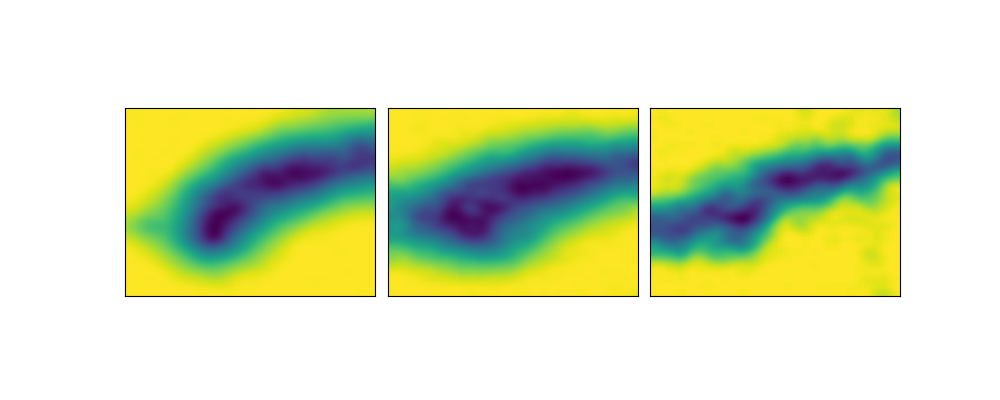

In [32]:
transformer = get_ILSVRC_net_transformer(net)
interested_idx = [87] # interested_idx = [31,50,67,71,87]
for i in interested_idx:
    img_fig_path = None
    mask_fig_path = None
    if save_figs:
        img_fig_path = os.path.join(fig_dir, 'perturbations_%d.pdf' % i)
        mask_fig_path = os.path.join(fig_dir, 'perturbations_masks_%d.pdf' % i)
    if generate_masks:
        mask_path = os.path.join(mask_dir, '%d.npy' % i)
        generate_learned_mask(net, img_path, label, mask_path = mask_path, gpu = gpu, show_fig = False)
        constant_mask_path = os.path.join(mask_dir, 'constant_%d.npy' % i)
        generate_learned_mask(net, img_path, label, null_type = 'mean_img', mask_path = mask_path, gpu = gpu, 
                              show_fig = False)
        noise_mask_path = os.path.join(mask_dir, 'constant_%d.npy' % i)
        generate_learned_mask(net, img_path, label, null_type = 'random_noise', mask_path = mask_path, gpu = gpu, 
                              show_fig = False)
        mask_ps = [mask_path, constant_mask_path, noise_mask_path]
    else:
        mask_ps = [mask_paths[i], constant_mask_paths[i], noise_mask_paths[i]]
    generate_perturbations_figure(transformer, paths[i], 
                                  [mask_paths[i], constant_mask_paths[i], noise_mask_paths[i]],
                                  show_masks = False,
                                  fig_path = img_fig_path)
    generate_perturbations_figure(transformer, paths[i], 
                                  [mask_paths[i], constant_mask_paths[i], noise_mask_paths[i]],
                                  show_masks = True,
                                  fig_path = mask_fig_path)

# Artifacts Figure (Figure 5)

<IPython.core.display.Javascript object>


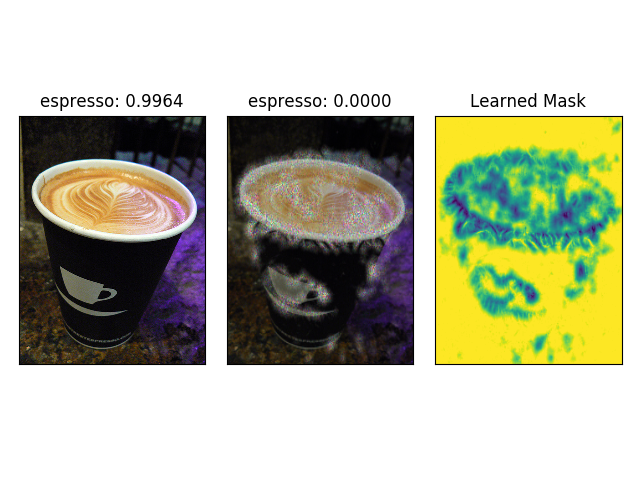

<IPython.core.display.Javascript object>


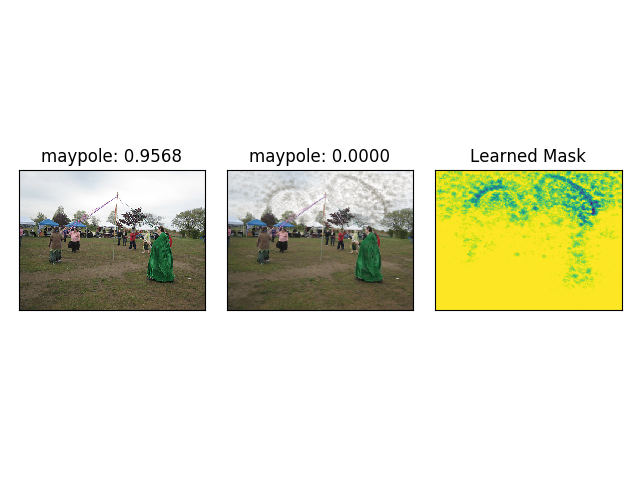

In [51]:
interested_idx = [9, 4]
arts_perturbs = ['random_noise', 'mean_img']

# if the artifact mask paths are already generated, include them here; otherwise, generate them below
arts_mask_paths = ['/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_avg_blur_blank_noise/lr_0_l1_lambda_-5.00_tv_lambda_-3.00_beta_3.00_jitter_4_noise_-3.0_num_iters_300_tv2/9.npy', 
                  '/data/ruthfong/neural_coding/pycaffe_results/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_mean_img/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_1_blur_mask_0_jitter_4_noise_-inf_num_iters_300_tv2/4.npy']
for i in range(len(interested_idx)):
    path = paths[interested_idx[i]]
    label = labels[interested_idx[i]]
    if generate_masks:
        if interested_idx[i] == 9:
            mask_path = os.path.join(mask_dir, '%d_artifact.npy' % interested_idx[i])
            generate_learned_mask(net, path, label, mask_path = mask_path, null_type = 'avg_blur_blank_noise', 
                                  lr = 1e0, l1_lambda = 1e-5, tv_lambda = 1e-3, noise = 1e-3, num_top = 5, 
                                  mask_scale = 1, blur_mask = 0, gpu = gpu, mask_init_type = None, show_fig = False)
        elif interested_idx[i] == 4:
            mask_path = os.path.join(mask_dir, '%d_artifact.npy' % interested_idx[i])
            generate_learned_mask(net, path, label, mask_path = mask_path, null_type = 'mean_img', 
                                  mask_scale = 1, blur_mask = 0, num_top = 5, 
                                  gpu = gpu, mask_init_type = None, show_fig = False)
        else:
            assert(False)
    else:
        mask_path = arts_mask_paths[i]
    perturbation = arts_perturbs[i]
    fig_path = None
    if save_figs:
        fig_path = os.path.join(fig_dir, 'artifacts_%s_%d.pdf' % (perturbation, interested_idx[i]))
    generate_splash_img(net, path, label, mask_path, perturbation = perturbation, fig_path = fig_path)

# Interrogating Suppressive Effects (Figure 6)

<IPython.core.display.Javascript object>


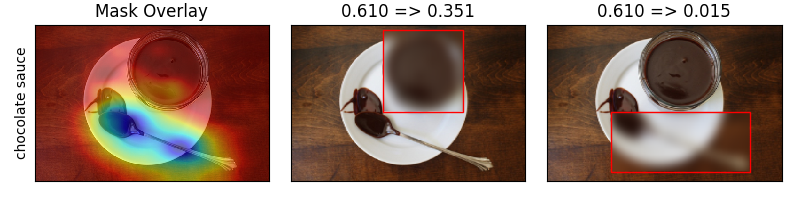

In [52]:
# chocolate sauce
ind = 12
img_path = paths[ind]
label = labels[ind]
ann_path = ann_paths[ind]

if generate_masks:
    mask_path = os.path.join(mask_dir, '%d.npy' % ind)
    generate_learned_mask(net, img_path, label, mask_path = mask_path, gpu = gpu, show_fig = False)
else:
    mask_path = mask_paths[ind]

# disp_img(img_path, (224,224)) # use to find coordinates of bounding boxes on resized 224x224 image

obj1_bb = [88, 7, 164, 124] # pot
obj2_bb = [61, 125, 193, 210] # spoon

objs_bbs = [obj1_bb, obj2_bb]
pylab.rcParams['figure.figsize'] = (8, 2.0)
fig_path = None
if save_figs:
    fig_path = os.path.join(fig_dir, 'chocolate_masked_example.pdf')

manual_edit_img(net, img_path, label, mask_path, objs_bbs, fig_path = fig_path, labels_desc = labels_desc)

<IPython.core.display.Javascript object>


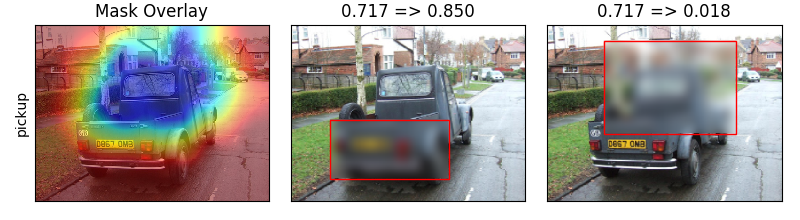

In [53]:
# pick up truck
ind = 30
img_path = paths[ind]
label = labels[ind]
ann_path = ann_paths[ind]

if generate_masks:
    mask_path = os.path.join(mask_dir, '%d.npy' % ind)
    generate_learned_mask(net, img_path, label, mask_path = mask_path, gpu = gpu, show_fig = False)
else:
    mask_path = mask_paths[ind]

# see contrastive excitation backprop saliency map (and choose bounding box coordinates)
#transformer = get_ILSVRC_net_transformer(net)
#heatmap = compute_heatmap(net, transformer, img_path, label, 'contrast_excitation_backprop', 'loss3/classifier', 'loss3/classifier',
#                    outputBlobName = 'pool3/3x3_s2', outputLayerName = 'pool3/3x3_s2', secondTopBlobName = 'pool5/7x7_s1',
#                    secondTopLayerName = 'pool5/7x7_s1', norm_deg = -2, gpu = gpu)
#f, ax = plt.subplots(1,1)
#ax.imshow(imresize(heatmap, (224,224)))

# see learned mask (and choose bounding box coordinates)
#mask = np.load(mask_path)
#f, ax = plt.subplots(1,1)
#ax.imshow(mask)

# disp_img(img_path, (224,224))

obj1_bb = [37,120,150,195] # contrast_excitation_backprop
obj2_bb = [54,20,180,138] # mask

objs_bbs = [obj1_bb, obj2_bb]

fig_path = None
if save_figs:
    fig_path = os.path.join(fig_dir, 'chocolate_masked_example.pdf')

pylab.rcParams['figure.figsize'] = (8, 2.2)
manual_edit_img(net, img_path, label, mask_path, objs_bbs, fig_path = fig_path)

# Deletion Region Representativeness Experiment (Figures 7 and 8)

<IPython.core.display.Javascript object>


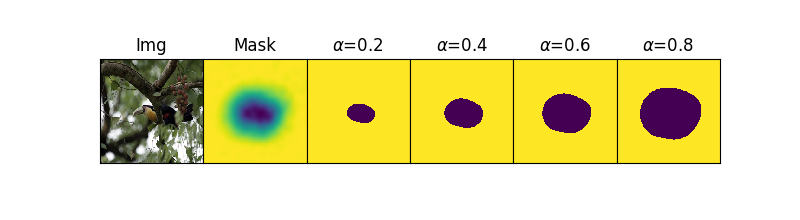

<IPython.core.display.Javascript object>


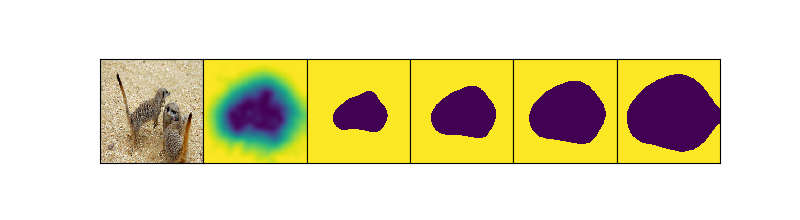

In [54]:
interested_idx = [5,6]

transformer = get_ILSVRC_net_transformer(net)
alphas = np.arange(0.2,1.0,0.2)

for j in range(len(interested_idx)):
    ind = interested_idx[j]
    path = paths[ind]
    label = labels[ind]
    
    if generate_masks:
        mask_path = os.path.join(mask_dir, '%d.npy' % ind)
        generate_learned_mask(net, img_path, label, mask_path = mask_path, gpu = gpu, show_fig = False)
    else:
        mask_path = mask_paths[ind]

    show_titles = True if j == 0 else False
    fig_path = os.path.join(fig_dir, 'sanity_check_test_%d.pdf' % ind) if save_figs else None
    deletion_region_exp_setup_fig(path, label, mask_path, transformer, alphas = alphas, show_titles = show_titles, 
                                  fig_path = fig_path)

## Pre-reqs:
* Learn optimized masks for 5000 heldout images (Run `python optimize_mask.py`)
* Run `python deletion_region_representativeness.py`

<IPython.core.display.Javascript object>


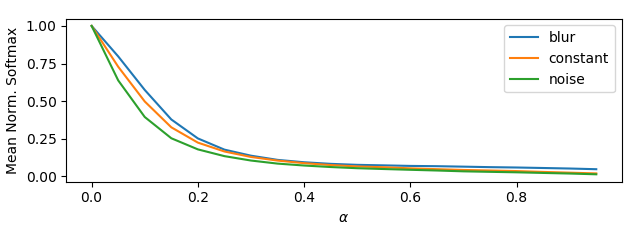

In [68]:
alphas = np.arange(0,1.0,0.05)
pylab.rcParams['figure.figsize'] = [6.4, 2.4]
perturbations = ['blur', 'mean_img', 'random_noise']
disp_names = ['blur', 'constant', 'noise']

# TODO: Replace with the directory/paths in which deletion representativeness experiment scores were saved
score_paths = ['/home/ruthfong/neural_coding/sanity_check_test/googlenet_train_heldout_%s_scores.txt' % p for p in perturbations]
scores = []

fig_path = None
if save_figs:
    fig_path = os.path.join(fig_dir, 'sanity_check_test_graph_shrink.pdf')
for i in range(len(score_paths)):
    scores.append(np.loadtxt(score_paths[i]))
scores = np.array(scores)
f, ax = plt.subplots(1,1)
for i in range(3):
    means = np.zeros(len(alphas))
    for j in range(len(alphas)):
        x = scores[i,:,j]
        x = x[np.invert(np.isnan(x))]
        x = np.maximum(0,np.minimum(x,1))
        means[j] = x.mean()
    ax.plot(alphas, means, label=disp_names[i])
    #ax.errorbar(alphas, means, yerr=x.std(), label=perturbations[i])
ax.legend(loc='upper right')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Mean Norm. Softmax')
plt.tight_layout()

plt.savefig(, bbox_inches='tight', pad_inches=0.0)

# Deletion Game (Figure 9)

## Pre-reqs:
* Learn optimized masks for 5000 heldout images (Run `python optimize_mask.py`)
* Run `python deletion_game.py`

<IPython.core.display.Javascript object>


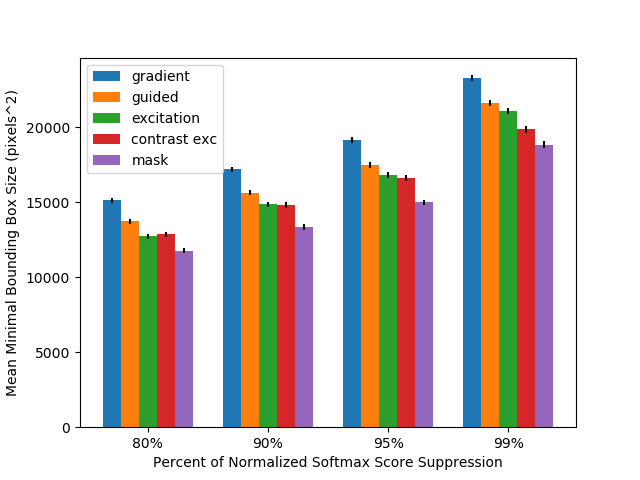

In [72]:
fig_path = os.path.join(fig_dir, 'deletion_game_bar.pdf') if save_figs else None

base_dir = '/home/ruthfong/neural_coding/deletion_game/googlenet_train_heldout/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
heatmap_types = ['saliency', 'guided_backprop', 'excitation_backprop', 'contrast_excitation_backprop', 'mask']
num_imgs = len(labels)
alphas = np.arange(0,1,0.01)
scores = np.zeros((len(heatmap_types), num_imgs, len(alphas)))
bb_sizes = np.zeros((len(heatmap_types), num_imgs, len(alphas)))

for i in range(len(heatmap_types)):
    heatmap_type = heatmap_types[i]
    bb_size = np.loadtxt(os.path.join(base_dir, 'bb_sizes_num_imgs_5000_%s.txt' % heatmap_type))
    score = np.loadtxt(os.path.join(base_dir, 'alpha_scores_num_imgs_5000_%s.txt' % heatmap_type))
    bb_sizes[i,...] = bb_size[:num_imgs]
    scores[i,...] = score[:num_imgs]

thresholds = np.arange(0.01,1.01,0.01)
best_bb_sizes = np.zeros((len(heatmap_types),num_imgs,len(thresholds)))
count = 0
normalize = False
for i in range(len(thresholds)):
    threshold = thresholds[i]
    for j in range(num_imgs):
        for k in range(len(heatmap_types)):
            try: 
                best_i = np.where(scores[k][j] <= threshold)[0][-1]
                best_bb_sizes[k][j][i] = bb_sizes[k][j][best_i]
            except:
                #print j, heatmap_types[k]
                best_bb_sizes[k][j][i] = np.nan
                count += 1
        if normalize:
            best_bb_sizes[:,j,i] = best_bb_sizes[:,j,i]/float(best_bb_sizes[0,j,i])

means = np.zeros((len(thresholds), len(heatmap_types)))
stds = np.zeros((len(thresholds), len(heatmap_types)))
counts = np.zeros((len(thresholds), len(heatmap_types)))

for i in range(len(thresholds)):
    for j in range(len(heatmap_types)):
        x = best_bb_sizes[j,:,i]
        x = x[~np.isnan(x)]
        #print thresholds[i], heatmap_types[j], x.mean(), x.std()
        means[i,j] = x.mean()
        stds[i,j] = x.std()
        counts[i,j] = len(x)

threshold_points = [19,9,4,0]  # corresponds with 80%, 90%, 95%, 99% score suppression (thresholds 20%, 10%, 5%, and 1% resp.)
# print thresholds[threshold_points]

bar_data = np.zeros((len(threshold_points),len(heatmap_types)))
bar_se = np.zeros((len(threshold_points), len(heatmap_types)))
width = 0.15
for i in range(len(threshold_points)):
    t_i = threshold_points[i]
    bar_data[i,:] = means[t_i]
    bar_se[i,:] = np.true_divide(stds[t_i],counts[t_i]**0.5)

pylab.rcParams['figure.figsize'] = [6.4, 4.8]
f, ax = plt.subplots(1,1)
for i in range(len(heatmap_types)):
    ax.bar([j+i*width for j in range(len(threshold_points))], bar_data[:,i], width, label=heatmap_types[i], yerr=bar_se[:,i])

ax.set_xlabel('Percent of Normalized Softmax Score Suppression')
ax.set_ylabel('Mean Minimal Bounding Box Size (pixels^2)')
ax.set_xticks(np.arange(len(threshold_points)) + 2*width)
ax.set_xticklabels(('80%', '90%', '95%', '99%'))

ax.legend(('gradient', 'guided', 'excitation', 'contrast exc', 'mask'))

if fig_path is not None:
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.0)

# Animal Parts Example (Figure 10)

## Pre-reqs:
* Download animal parts annotations from [here](http://www.robots.ox.ac.uk/~vgg/data/animal_parts)
* (Optional) Learn optimized masks for the 3558 annotated animal images to generate statistics for each animal class (Run `python optimize_mask.py animals`)

In [72]:
generate_animal_imdb = False

animal_imdb_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_imdb.txt'
foot_num_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_foot_num_imdb.txt'
eye_num_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_eye_num_imdb.txt'
foot_dir = '/data/ruthfong/ILSVRC2012/animal_parts_dataset/xml/foot'
eye_dir = '/data/ruthfong/ILSVRC2012/animal_parts_dataset/xml/eye'

if generate_animal_imdb:
    (_,_) = create_animal_parts_imdb(out_file = animal_imdb_file, 
                                     foot_num_file = foot_num_file, 
                                     eye_num_file = eye_num_file, 
                                     require_eye_and_foot = True, 
                                     min_per_class = 10)
else:
    (animal_paths, animal_labels) = read_imdb(animal_imdb_file)
    (_, foot_num) = read_imdb(foot_num_file)
    (_, eye_num) = read_imdb(eye_num_file)

# TODO set to where animal masks are saved (or where you want to save them)
animal_mask_dir = '/data/ruthfong/neural_coding/pycaffe_results/googlenet_animal_parts_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
if generate_masks:
    animal_mask_paths = [os.path.join(animal_mask_dir, '%d.npy' % x) for x in range(len(animal_labels))]

<IPython.core.display.Javascript object>


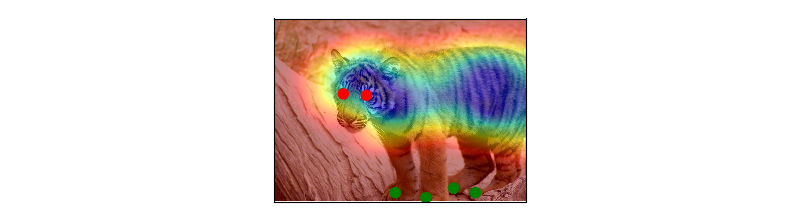

<IPython.core.display.Javascript object>


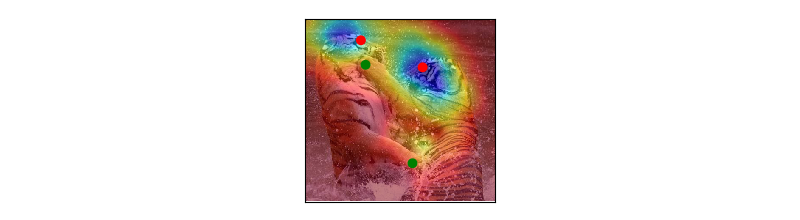

<IPython.core.display.Javascript object>


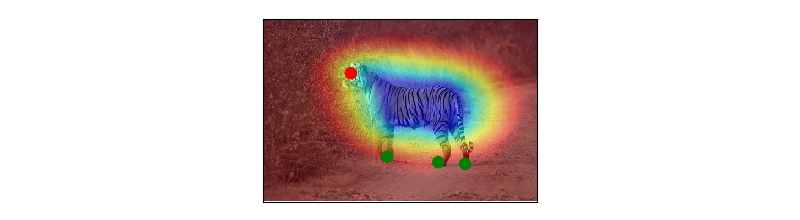

<IPython.core.display.Javascript object>


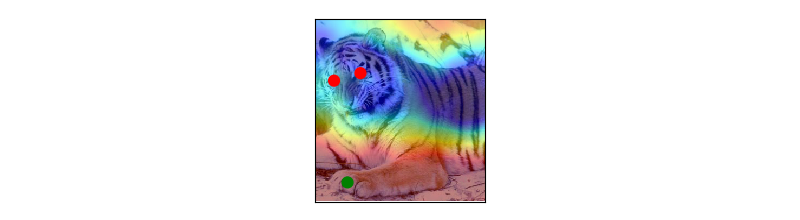

<IPython.core.display.Javascript object>


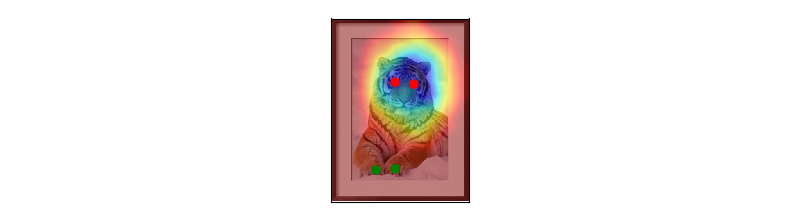

<IPython.core.display.Javascript object>


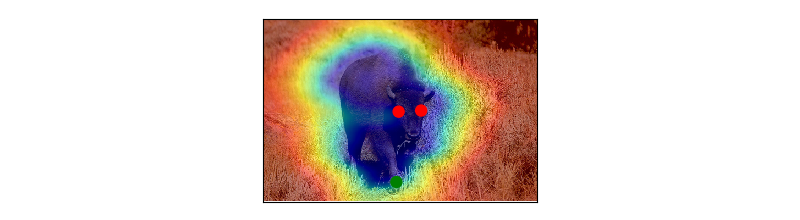

<IPython.core.display.Javascript object>


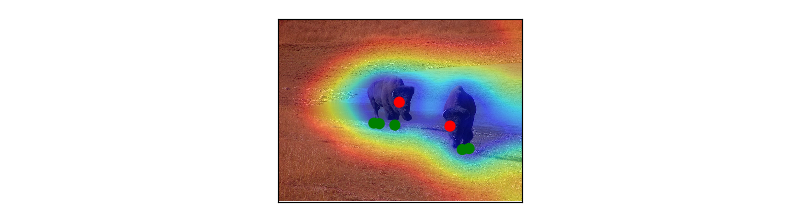

<IPython.core.display.Javascript object>


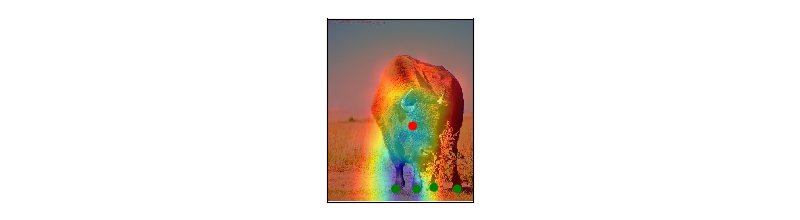

<IPython.core.display.Javascript object>


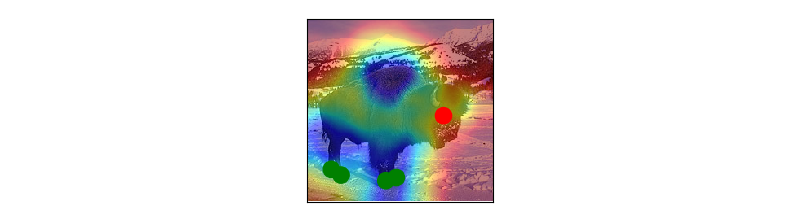

<IPython.core.display.Javascript object>


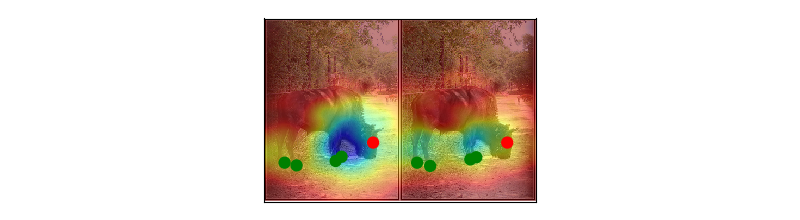

In [79]:
window_size = 5
interested_labels = [292, # tiger, 
                    347 # bison
                    ]
for i in interested_labels:
    label = i
    idx = np.where(animal_labels == label)[0]
    
    avg_eyes_intensity = []
    avg_feet_intensity = []
    for j in idx[:5]:
        fig_path = None
        if save_figs:
            fig_path = os.path.join(fig_dir, 'animal_%d_ex_%d.pdf' % (i, j))
        
        if generate_masks:
            mask_path = os.path.join(animal_mask_dir, '%d_animal.npy' % j)
            generate_learned_mask(net, animal_paths[j], animal_labels[j], mask_path = mask_path, gpu = gpu, 
                                  show_fig = False)
        else:
            mask_path = animal_mask_paths[j]
    
        heatmap = np.load(mask_path)
        resize = caffe.io.load_image(animal_paths[j]).shape[:2]
        heatmap = imresize(heatmap, resize)/float(255)
        f = animal_paths[j].split('/')[-1].strip('.JPEG') + '.xml'
        foot_ann = os.path.join(foot_dir, f)
        eye_ann = os.path.join(eye_dir, f)
        foot_objs = load_objs(foot_ann)
        eye_objs = load_objs(eye_ann)
        
        f, ax = plt.subplots(1,1)
        ax.imshow(caffe.io.load_image(animal_paths[j]))

        num_feet = len(foot_objs['foot'])
        assert(num_feet == foot_num[j])
        for k in range(num_feet):
            (x,y) = foot_objs['foot'][k]
            x, y = int(x), int(y)
            ax.add_artist(plt.Circle((x, y), 10, color='g'))
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_feet_intensity.append(avg_intensity)
            #print 'foot:', avg_intensity
        num_eyes = len(eye_objs['eye'])
        assert(num_eyes == eye_num[j])
        for k in range(num_eyes):
            (x,y) = eye_objs['eye'][k]
            x, y = int(x), int(y)
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_eyes_intensity.append(avg_intensity)
            ax.add_artist(plt.Circle((x, y), 10, color='r'))
            #print 'eye:', avg_intensity

        ax.imshow(heatmap, alpha = 0.5, cmap = 'jet')
        #print avg_eyes_intensity[-1], avg_feet_intensity[-1]
            
        ax.get_xaxis().set_visible(False)                                                                                               
        ax.get_yaxis().set_visible(False)
        plt.tight_layout()
        
        if save_figs:
            plt.savefig(fig_path, bb_inches='tight', pad_inches=0.0)

    avg_feet_intensity = np.array(avg_feet_intensity)
    avg_eyes_intensity = np.array(avg_eyes_intensity)

    #print avg_eyes_intensity.mean(), avg_feet_intensity.mean()

## Pre-req for actual experiment:
* Learn optimized masks for the 3558 annotated animal images to generate statistics for each animal class (Run `python optimize_mask.py animals`)

In [80]:
unique_labels = np.unique(animal_labels)
window_size = 5

mean_eyes_intensity = np.zeros(len(unique_labels))
mean_feet_intensity = np.zeros(len(unique_labels))
stderr_eyes_intensity = np.zeros(len(unique_labels))
stderr_feet_intensity = np.zeros(len(unique_labels))

for i in range(len(unique_labels)):
    label = unique_labels[i]
    idx = np.where(animal_labels == label)[0]
    
    avg_eyes_intensity = []
    avg_feet_intensity = []
    for j in idx:
        heatmap = np.load(animal_mask_paths[j])
        resize = caffe.io.load_image(animal_paths[j]).shape[:2]
        heatmap = imresize(heatmap, resize)/float(255)
        f = animal_paths[j].split('/')[-1].strip('.JPEG') + '.xml'
        foot_ann = os.path.join(foot_dir, f)
        eye_ann = os.path.join(eye_dir, f)
        foot_objs = load_objs(foot_ann)
        eye_objs = load_objs(eye_ann)
        
        num_feet = len(foot_objs['foot'])
        assert(num_feet == foot_num[j])
        for k in range(num_feet):
            (x,y) = foot_objs['foot'][k]
            x, y = int(x), int(y)
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_feet_intensity.append(avg_intensity)
        num_eyes = len(eye_objs['eye'])
        assert(num_eyes == eye_num[j])
        for k in range(num_eyes):
            (x,y) = eye_objs['eye'][k]
            x, y = int(x), int(y)
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_eyes_intensity.append(avg_intensity)
            
    avg_feet_intensity = np.array(avg_feet_intensity)
    avg_eyes_intensity = np.array(avg_eyes_intensity)

    mean_feet_intensity[i] = avg_feet_intensity.mean()
    stderr_feet_intensity[i] = avg_feet_intensity.std()/float(len(avg_feet_intensity)**0.5)
    mean_eyes_intensity[i] = avg_eyes_intensity.mean()
    stderr_eyes_intensity[i] = avg_eyes_intensity.std()/float(len(avg_eyes_intensity)**0.5)
    #print '%s (# = %d): avg feet intensity = %.4f (std_err = %.4f), avg eye intensity = %.4f (std_err = %.4f)' % (get_short_class_name(label), 
    #                                                                                                            len(idx),
    #                                                                                                             mean_feet_intensity[i],
    #                                                                                                             stderr_feet_intensity[i],
    #                                                                                                             mean_eyes_intensity[i],
    #                                                                                                             stderr_eyes_intensity[i])

diff_intensity = mean_eyes_intensity - mean_feet_intensity
sorted_idx = np.argsort(diff_intensity)[::-1]
print 'animal num_samples mean_eyes mean_feet stderr_eyes stderr_feet'
for i in sorted_idx:
    print '%s %d %.4f %.4f %.4f %.4f' % ('_'.join(get_short_class_name(unique_labels[i]).split()), 
                                         len(np.where(animal_labels == unique_labels[i])[0]), 
                                         mean_eyes_intensity[i], mean_feet_intensity[i], 
                                         stderr_eyes_intensity[i], stderr_feet_intensity[i])

animal num_samples mean_eyes mean_feet stderr_eyes stderr_feet
bison 22 0.3329 0.3559 0.0441 0.0329
water_ouzel 89 0.1473 0.2620 0.0157 0.0159
sloth_bear 23 0.1993 0.3236 0.0331 0.0383
jacamar 224 0.1339 0.2629 0.0084 0.0101
banded_gecko 59 0.3263 0.4583 0.0368 0.0245
spotted_salamander 69 0.3226 0.4613 0.0204 0.0178
bee_eater 75 0.1279 0.2849 0.0184 0.0204
armadillo 31 0.2568 0.4149 0.0415 0.0338
platypus 23 0.1489 0.3137 0.0259 0.0395
alligator_lizard 70 0.2600 0.4349 0.0295 0.0246
hummingbird 53 0.1234 0.3012 0.0203 0.0244
spoonbill 87 0.2025 0.3902 0.0219 0.0219
African_chameleon 67 0.2986 0.4908 0.0299 0.0239
warthog 25 0.2156 0.4133 0.0268 0.0348
wallaby 27 0.2445 0.4548 0.0336 0.0384
indigo_bunting 86 0.0747 0.2935 0.0070 0.0193
hamster 66 0.0672 0.3038 0.0066 0.0219
water_buffalo 47 0.2460 0.4909 0.0256 0.0225
ruffed_grouse 105 0.2672 0.5237 0.0235 0.0210
hartebeest 13 0.2698 0.5327 0.0488 0.0348
llama 11 0.3574 0.6231 0.0546 0.0441
quail 52 0.1914 0.4606 0.0198 0.0225
tusker 2

# Weak Localization (Table 1)
## See localization.ipynb